## Ансамбли


### Бэггинг


* Сделаем несколько псевдовыборок ($X_1, \ldots, X_B$) из нашей выборки $X$.
* Обучим на каждой псевдовыборке один и тот же алгоритм $a_1(\cdot), \ldots a_B(\cdot)$.
* А результат будем получать как среднее из выходов обученных моделей $$a(x) = \frac{1}{B}\sum_{i=1}^{B}a_i(x)$$

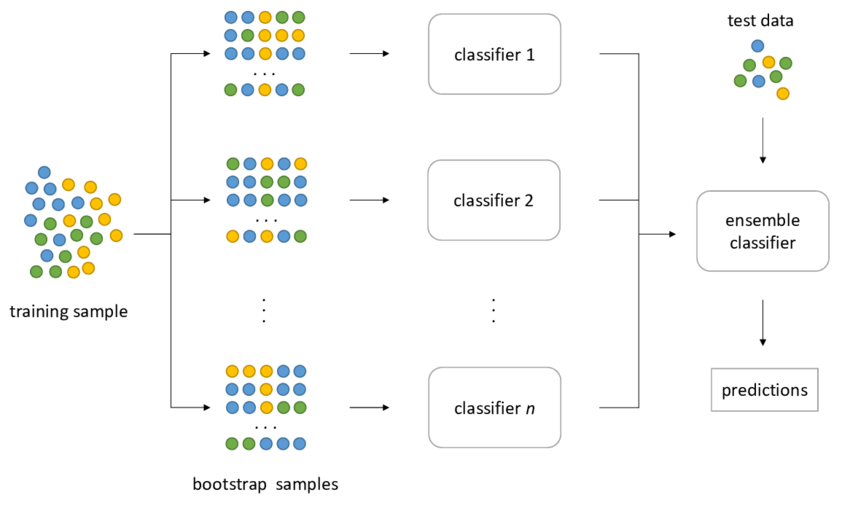

In [25]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor


X, y = make_regression(
    n_samples=100,
    n_features=4, 
    n_informative=2,
    random_state=0
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

dtr = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)

br = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=3), #выбрали тип алгоритма a(x)
    n_estimators=30, #количество регрессоров B 
    ).fit(X_train, y_train)

rf = RandomForestRegressor(
    n_estimators=30,
    max_depth=3
).fit(X_train, y_train)

print('DTR Loss: {} \nBagging Loss: {}\nRF: {}'.format(
    MSE(dtr.predict(X_test), y_test),
    MSE(br.predict(X_test), y_test),
    MSE(rf.predict(X_test), y_test)
    )
)

DTR Loss: 456.25171963879046 
Bagging Loss: 158.79834805165612
RF: 165.6061807641599


## Бустинг


#### Интуиция

Давайте дообучать каждый следующий алгоритм на ошибках предыдущего, чтобы уменьшать ошибку на объектах.

Пример с экзаменом


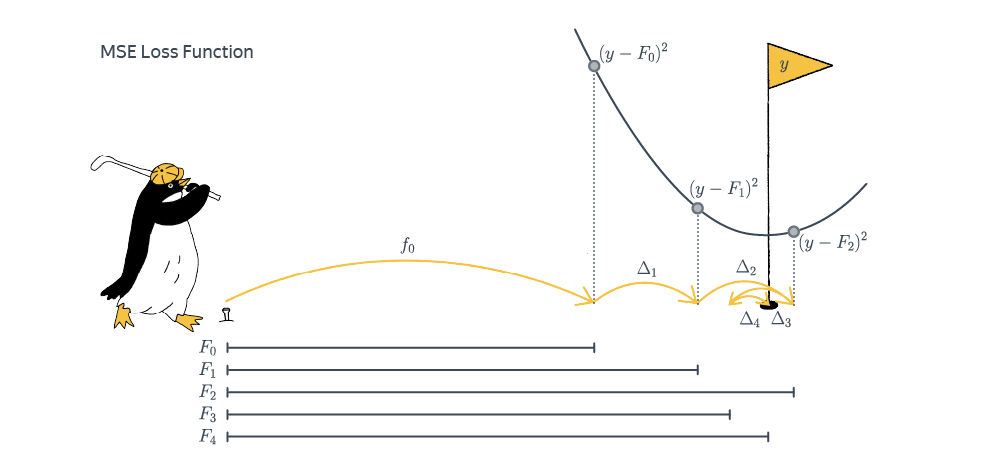

Пусть мы построили алгоритм $a(x)$. Давайте теперь построим алгоритм $b(x)$ такой, что $$a\left(x_i\right)+b\left(x_i\right)=y_i, i \in\{1,2, \ldots, M\}$$

Идея в том, что алгоритм $a$ наверняка где-то ошибся, и мы можем попытаться исправить эти ошибки с помощью алгоритма $b$. Алгоритм $b$ тоже не идеален, поэтому сумма $a$ и $b$ тоже где-то ошибётся. Что ж, заведём алгоритм $c$...

Главный вопрос здесь – как обучить второй и дальнейшие алгоритмы.

У нас есть наша лосс фукнция, которую мы хотим минимизировать. 
Можем посчитать градиент у нее. По чему?

Наверное по ответам предыдущей модели. Ведь тогда мы узнаем ее "ошибки".


Получается, что можем считать $$r=-L^{\prime}\left(y, a\left(x\right)\right)$$, где $ r $ - ответы "поправляющего" алгоритма b


а  $ L^{\prime}$ - градиент нашей фукнции потерь



## Важный частный случай
Рассмотрим отдельно случай
$$L(y, a)=\frac{1}{2}(y-a)^2$$

Заметим, что тогда
$$L^{\prime}(y, a)=-(y-a)$$

И алгоритм $b_t(x)$ обучается на выборке
$$\left(x_i, y_i-a_t\left(x_i\right)\right)_{i=1}^m$$

т.е. пытается просто реализовать поправки к ответам текущего алгоритма $a_t(x)$


### Простейший алгоритм градиентного бустинга
- Инициализация композиции оптимальным константным значением 

$$a_0 = \arg\min_{c \in \mathbb{R}} \sum_{i=1}^n \mathcal{L}(c, y_i)$$ 

- Для всех $k = 1, \dots, T$:
    * Вычислить градиент ошибки предыдущей композиции: 
    
    $$g_{i}^{k} = -\Big[\frac{\partial \mathcal{L}(a_k, x_i, y_i)}{\partial a_k(x_i)}\Big]_{i=1}^N$$
    
    * Настроить базовую регрессию $b_k(x)$ на полученные остатки, т.е. обучить его по выборке $\{(x_i, g_{i}^{k}), i = 1, \dots, n\}$.
    
    * Добавить полученное слагаемое в композицию: $a_k(x) = a_{k-1}(x) + b_k(x)$.

В результате получаем алгоритм $a(x) = a_T(x) = \sum_{t=1}^T b_t(x)$

Чтобы получить предсказание достаточно получить результат: $y_{pred} = a(x_{pred})$

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=36, #зададим количество деревеьев
    loss='squared_error', # MSE
    max_depth=3, #невысокие деревья, но не "пеньки"
    random_state=128
).fit(X_train, y_train)


print('DTR: {} \nBagging: {}\nBoosting: {}'.format(
    MSE(dtr.predict(X_test), y_test),
    MSE(br.predict(X_test), y_test),
    MSE(gbr.predict(X_test), y_test))
)

DTR: 456.25171963879046 
Bagging: 158.79834805165612
Boosting: 93.55877497820732


В общем случае можно не думая применять catboost, он из коробки (не настраивая гиперпараметры) будет выдавать очень крутое качество. 

Еще внутри он обрабатывает категориальные фичи, их можно не предобрататывать, а просто передать названия фичей через cat_features


In [ ]:
%pip install catboost

In [27]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()
# Fit model
model.fit(
    X_train,
    y_train,
    # cat_features=["name", "boat"], 
    # text_features=[""]
    )
# Get predictions
preds = model.predict(X_test)
MSE(preds, y_test)


Learning rate set to 0.026897
0:	learn: 39.0590516	total: 1.23ms	remaining: 1.23s
1:	learn: 38.6304167	total: 1.7ms	remaining: 847ms
2:	learn: 38.1801537	total: 1.94ms	remaining: 644ms
3:	learn: 37.6646857	total: 2.18ms	remaining: 543ms
4:	learn: 37.1897986	total: 2.44ms	remaining: 486ms
5:	learn: 36.7360527	total: 2.7ms	remaining: 447ms
6:	learn: 36.1638265	total: 3.07ms	remaining: 436ms
7:	learn: 35.7119974	total: 3.33ms	remaining: 412ms
8:	learn: 35.2683827	total: 3.58ms	remaining: 394ms
9:	learn: 34.7982954	total: 3.87ms	remaining: 383ms
10:	learn: 34.3141839	total: 4.12ms	remaining: 371ms
11:	learn: 33.8960592	total: 4.38ms	remaining: 361ms
12:	learn: 33.5445829	total: 4.69ms	remaining: 356ms
13:	learn: 33.0660176	total: 4.97ms	remaining: 350ms
14:	learn: 32.7252928	total: 5.21ms	remaining: 342ms
15:	learn: 32.3028552	total: 5.48ms	remaining: 337ms
16:	learn: 31.9372659	total: 5.7ms	remaining: 330ms
17:	learn: 31.4649461	total: 6ms	remaining: 328ms
18:	learn: 31.1142267	total: 6.2

87.49041211361909

In [30]:
# можем оценить важность фичей
model.feature_names_, model.feature_importances_

(['0', '1', '2', '3'],
 array([30.68065982, 61.27871193,  4.1169404 ,  3.92368786]))